In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm
import seaborn as sns

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    print("No TPUs detected")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

No TPUs detected
REPLICAS:  1


### Load Data

In [5]:
INPUT_DIR = "../butterflies_classfication/archive"
TRAIN_DIR = f"{INPUT_DIR}/train"
VALID_DIR = f"{INPUT_DIR}/valid"
TEST_DIR = f"{INPUT_DIR}/test"

# we will only use the training set provided, split this into a training and validation
# set, and use these to train our model
meta_df = pd.read_csv(os.path.join(INPUT_DIR, "butterflies_and_moths.csv"))
meta_df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


In [6]:
x = meta_df['data set'].unique()
print(x)

['train' 'test' 'valid']


In [7]:
meta_df.shape

(13594, 4)

In [8]:
butterfly_classes = meta_df['labels'].unique()
print("classes ", butterfly_classes)

classes  ['ADONIS' 'AFRICAN GIANT SWALLOWTAIL' 'AMERICAN SNOOT' 'AN 88' 'APPOLLO'
 'ARCIGERA FLOWER MOTH' 'ATALA' 'ATLAS MOTH' 'BANDED ORANGE HELICONIAN'
 'BANDED PEACOCK' 'BANDED TIGER MOTH' 'BECKERS WHITE'
 'BIRD CHERRY ERMINE MOTH' 'BLACK HAIRSTREAK' 'BLUE MORPHO'
 'BLUE SPOTTED CROW' 'BROOKES BIRDWING' 'BROWN ARGUS' 'BROWN SIPROETA'
 'CABBAGE WHITE' 'CAIRNS BIRDWING' 'CHALK HILL BLUE' 'CHECQUERED SKIPPER'
 'CHESTNUT' 'CINNABAR MOTH' 'CLEARWING MOTH' 'CLEOPATRA'
 'CLODIUS PARNASSIAN' 'CLOUDED SULPHUR' 'COMET MOTH' 'COMMON BANDED AWL'
 'COMMON WOOD-NYMPH' 'COPPER TAIL' 'CRECENT' 'CRIMSON PATCH'
 'DANAID EGGFLY' 'EASTERN COMA' 'EASTERN DAPPLE WHITE'
 'EASTERN PINE ELFIN' 'ELBOWED PIERROT' 'EMPEROR GUM MOTH'
 'GARDEN TIGER MOTH' 'GIANT LEOPARD MOTH' 'GLITTERING SAPPHIRE'
 'GOLD BANDED' 'GREAT EGGFLY' 'GREAT JAY' 'GREEN CELLED CATTLEHEART'
 'GREEN HAIRSTREAK' 'GREY HAIRSTREAK' 'HERCULES MOTH'
 'HUMMING BIRD HAWK MOTH' 'INDRA SWALLOW' 'IO MOTH' 'Iphiclus sister'
 'JULIA' 'LARGE MARBLE' '

In [9]:
num_classes = meta_df['labels'].nunique()
print(num_classes)

100


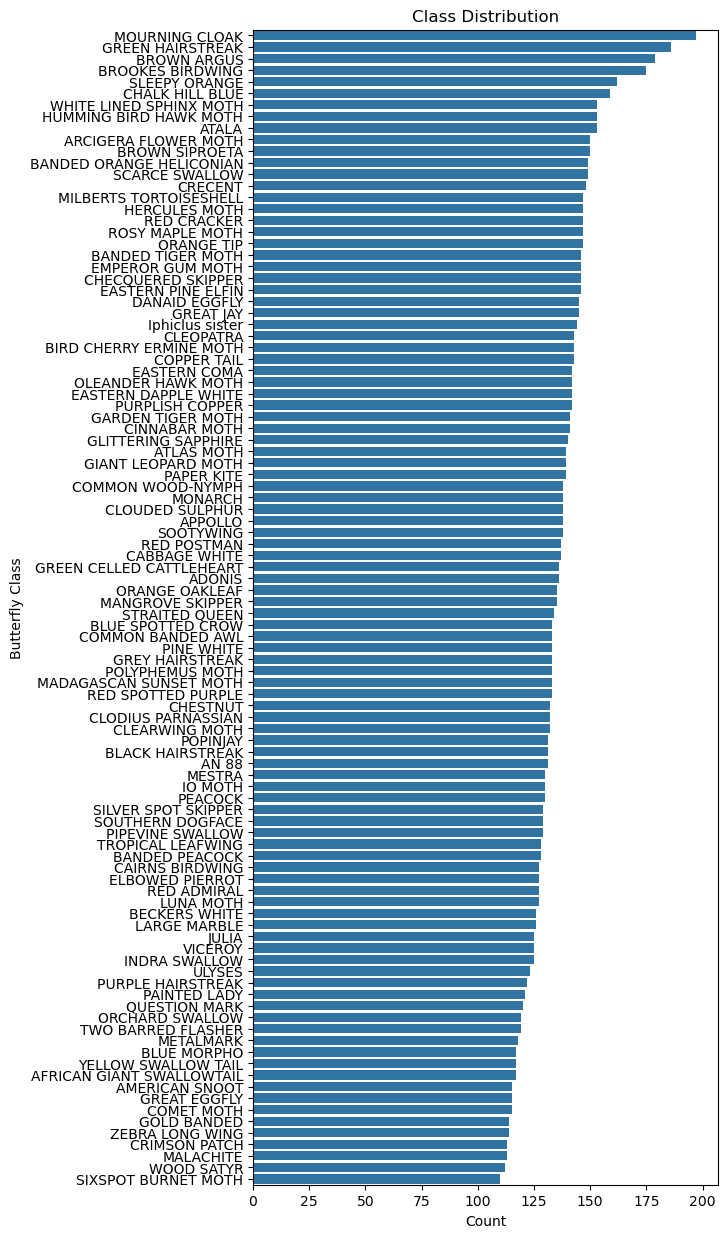

In [10]:
plt.figure(figsize=(6, 15))
sns.countplot(y='labels', data=meta_df, order=meta_df['labels'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Butterfly Class')
plt.title('Class Distribution')
plt.show()

### Data Preprocessing

In [11]:
images = []
labels = []
label_encodings = []

label_encoder = LabelEncoder()
meta_df["label_encoding"] = label_encoder.fit_transform(meta_df["labels"])
pbar = tqdm(list(meta_df.iterrows()))

for index, entry in pbar: 
    image = np.asarray(Image.open(os.path.join(INPUT_DIR, entry["filepaths"])))
    label = entry["labels"]
    label_encoding = entry["label_encoding"]
    
    images.append(image)
    labels.append(label)
    label_encodings.append(label_encoding)

100%|██████████| 13594/13594 [00:09<00:00, 1506.95it/s]


In [12]:
images[0].shape

(224, 224, 3)

In [13]:
labels[0:10]

['ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS',
 'ADONIS']

In [14]:
types= len(set(label_encodings))
print(types)

100


### Visualizing data

<Figure size 640x480 with 0 Axes>

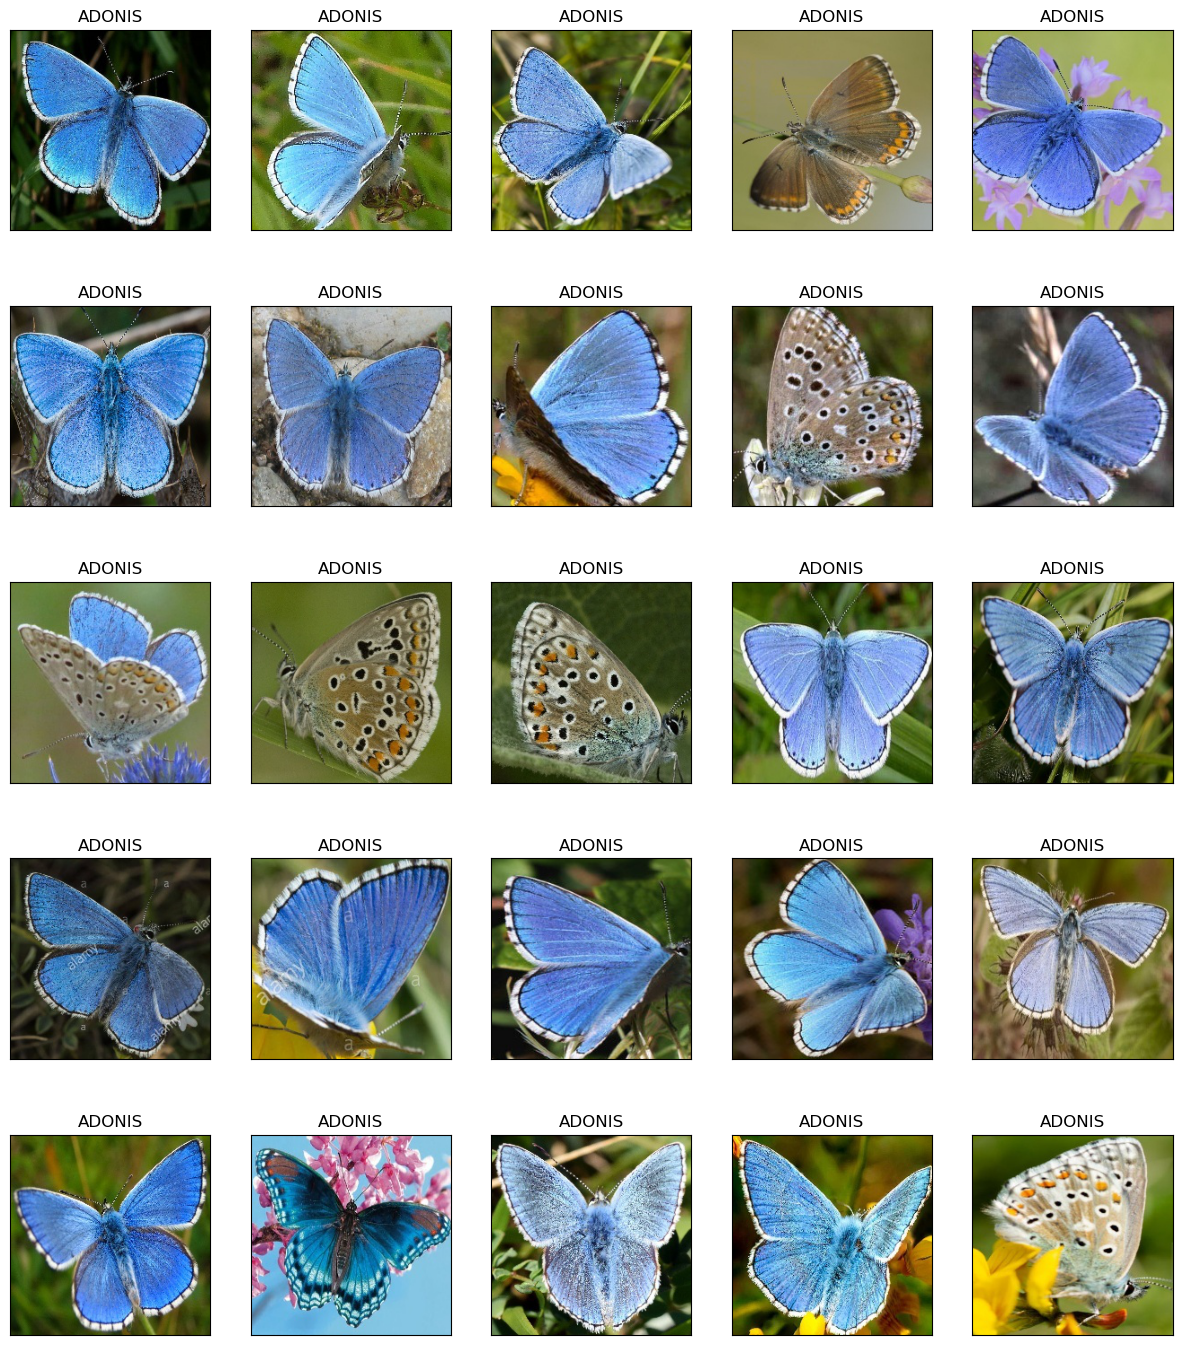

In [15]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
plt.subplots_adjust(top=1.0)

for idx, ax in enumerate(axes.flat):
    image = images[idx]
    label_name = labels[idx]
    
    ax.imshow(image)
    ax.set(title=label_name)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

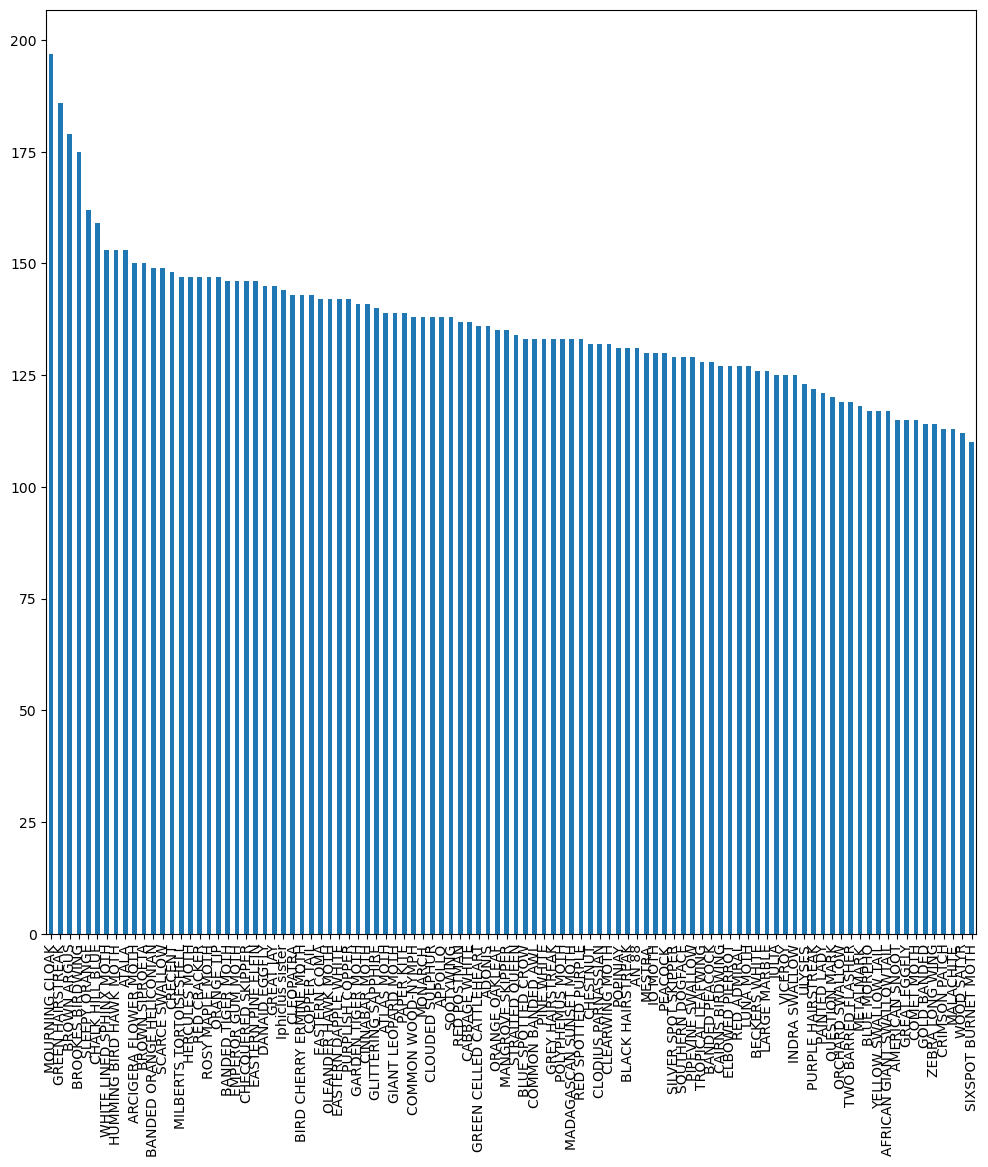

In [16]:
#Dsitribution of labels inthe dataset
plt.figure(figsize=(12, 12))
meta_df["labels"].value_counts().plot(kind="bar")

plt.show()

### Image Classification using EfficientNet v2 Model from Keras

In [17]:
# Importing required libraries
from tensorflow.keras.layers import Input,Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob

In [18]:
img_size = [224,224]

In [19]:
#downloading EfficientNet pre-trained model
enet_model = EfficientNetV2B2(input_shape=img_size + [3], weights= "imagenet", include_top= False)

2024-04-16 16:05:50.653560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-16 16:05:50.653614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [20]:
for layer in enet_model.layers:
    layer.trainable = False

In [21]:
for layer in enet_model.layers:
    print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_drop False
block2c_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation F

In [22]:
enet_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,769,374 (33.45 MB)

In [23]:
model = Sequential([
    enet_model,
#         keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(100, activation='softmax'),
])

model.build([None, 224, 224, 3])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 256)      │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7, 7, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7, 7, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,221,570 (35.18 MB)

 Trainable params: 452,196 (1.72 MB)

 Non-trainable params: 8,769,374 (33.45 MB)

### Training the Model

In [25]:
np_images = np.asarray(images).astype('float64') / 255
np_label_encodings = np.asarray(label_encodings).astype('float64')
print(f"Shape of images: {np_images.shape}")
print(f"Shape of label encodings: {np_label_encodings.shape}")

Shape of images: (13594, 224, 224, 3)
Shape of label encodings: (13594,)


In [26]:
images_train, images_test, label_encodings_train, label_encodings_test = train_test_split(np_images, np_label_encodings, train_size=0.7)
print(f"Shape of training images: {images_train.shape}")
print(f"Shape of training label encodings: {label_encodings_train.shape}")
print(f"Shape of validation images: {images_test.shape}")
print(f"Shape of validation label encodings: {label_encodings_test.shape}")

Shape of training images: (9515, 224, 224, 3)
Shape of training label encodings: (9515,)
Shape of validation images: (4079, 224, 224, 3)
Shape of validation label encodings: (4079,)


In [27]:
import tensorflow as tf

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, label_encodings_train)).repeat().shuffle(9515).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, label_encodings_test)).batch(1)

: 